# **TensorRT Optimization Demo**

This hands-on demo shows how **Torch-TensorRT** accelerates inference of a **pretrained ResNet-50** on an **NVIDIA GPU**. It compares **plain PyTorch (FP32)** vs **TensorRT-accelerated FP32** vs **TensorRT-accelerated FP16**, and measures **latency** and **throughput**.

## **Overview**
- Introduces **TensorRT ecosystem** (TensorRT, Model Optimizer, TensorRT-LLM, Torch-TensorRT, TRT Cloud CLI) and shows installation commands.
- Verifies GPU and sets up Jupyter (`ipywidgets`).
- Uses **Torch Hub / torchvision** to load a pretrained **ResNet-50** in eval mode.

## **Model & Data Setup**
- Downloads **JPEG images** and **ImageNet class index JSON** into `./data/`.
- Defines standard **ResNet-50 preprocessing**: `Resize(256) → CenterCrop(224) → ToTensor → Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`.

## **Inference & Visualization**
- Runs single-image inference on each file, applies **softmax**, and prints **top-1 class + probability**.
- Displays the four images in a 2×2 grid with predicted labels as titles.

## **Benchmarking Method**
- Enables `torch.backends.cudnn.benchmark = True`.
- Warms up the model; then measures **per-batch latency (ms)** with CUDA sync and computes **throughput (samples/sec)**.
- Benchmarks:
  - **PyTorch FP32** (baseline)
  - **Torch-TensorRT FP32** (IR: TorchScript)
  - **Torch-TensorRT FP16** (IR: TorchScript)

## **Results (Latency & Throughput)**

> **Speedup** is relative to **PyTorch FP32** at the **same batch size** (`speedup = PyTorch latency / engine latency`).

### **Batch Size = 8**
| Engine / Precision | Latency (ms) | Throughput (img/s) | Speedup vs PyTorch FP32 |
|---|---:|---:|---:|
| **PyTorch (FP32)** | **25.24**    | **316.63**         | **1.00×**               |
| TensorRT (FP32)    | 18.61        | 429.17             | **1.36×**               |
| TensorRT (FP16)    | 4.60         | 1731.96            | **5.49×**               |

### **Batch Size = 16**
| Engine / Precision | Latency (ms) | Throughput (img/s) | Speedup vs PyTorch FP32 |
|---|---:|---:|---:|
| **PyTorch (FP32)** | **43.84**    | **364.76**         | **1.00×**               |
| TensorRT (FP32)    | 36.94        | 432.76             | **1.19×**               |
| TensorRT (FP16)    | 8.02         | 1991.97            | **5.47×**               |


## **Key Takeaway**
- **Torch-TensorRT**, especially **FP16**, significantly reduces latency and **boosts throughput** for ResNet-50 compared to plain PyTorch FP32 on the tested GPU.


# **NVIDIA TensorRT**
NVIDIA® TensorRT™ is an SDK for high-performance deep learning inference. It is designed to work in a complementary fashion with training frameworks such as TensorFlow, PyTorch, and MXNet. It focuses specifically on running an already-trained network quickly and efficiently on NVIDIA hardware.

TensorRT includes a deep learning inference optimizer and runtime that delivers low latency and high throughput for deep learning inference applications. The core of NVIDIA TensorRT is a C++ library that facilitates high-performance inference on NVIDIA GPUs. TensorRT takes a trained network, which consists of a network definition and a set of trained parameters, and produces a highly optimized runtime engine that performs inference for that network

NVIDIA® TensorRT™ is an ecosystem of APIs for high-performance deep learning inference. TensorRT includes an inference runtime and model optimizations that deliver low latency and high throughput for production applications. The TensorRT ecosystem includes **TensorRT, TensorRT-LLM, TensorRT Model Optimizer, and TensorRT Cloud**.

https://github.com/NVIDIA/TensorRT

In [ ]:
pip install nvidia-tensorrt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.3 MB/s eta 0:00:00
  Created wheel for tensorrt: filename=tensorrt-10.13.2.6-py2.py3-none-any.whl size=46436 sha256=a50bb9b67a6a1bb98104b3f8797b6a60d4b743208789016365b5cb9ef6002380
  Stored in directory: /root/.cache/pip/wheels/5a/22/e7/4d28e4907a118d0a014adfec88205918792bb11cd061646091
  Created wheel for tensorrt_cu13: filename=tensorrt_cu13-10.13.2.6-py2.py3-none-any.whl size=17437 sha256=fa4430779df4d3159dc0dbaa5de54dcacf58f5f77971e1bcc69b34f53664a397
  Stored in directory: /root/.cache/pip/wheels/de/a4/19/4b06ee6d941601c0795594f260be07c42532c8a4a24cf6a1ff
  Created wheel for tensorrt_cu13_libs: filename=tensorrt_cu13_libs-10.13.2.6-

In [ ]:
!nvidia-smi

Sun Aug 24 18:53:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import sys; print("python:", sys.version)

python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]


# **Set up PyTorch 2.6 + Torch-TensorRT 2.6 (CUDA 12.4) and NVIDIA TensorRT Model Optimizer**

## **Torch-TensorRT**
Torch-TensorRT is a compiler for PyTorch models targeting NVIDIA GPUs via the TensorRT Model Optimization SDK. It aims to provide better inference performance for PyTorch models while still maintaining the great ergonomics of PyTorch

**torch_tensorrt.compile**

As there are many different frontends and supported formats, NVIDIA provides a convenience layer called torch_tensorrt.compile which lets users access all the different compiler options. One can specify to torch_tensorrt.compile what compiler path to use by setting the ir option, telling Torch-TensorRT to try to lower the provided model through a specific intermediate representation.

- **`torch_tensorrt.compile` is a one-stop wrapper.** Call this single function to compile a PyTorch model with Torch-TensorRT.
- **Pick the route with `ir=`.** The `ir` option (e.g., `"torchscript"`, `"dynamo"`, `"torch_compile"`, `"fx"`) tells Torch-TensorRT which frontend/graph form to use when converting a model.
- **“Lowering” = translating to TensorRT.** Torch-TensorRT takes the parts of the model it understands and **converts (lowers)** them into fast TensorRT ops; anything unsupported can stay in regular PyTorch (unless you require full compilation).
- **With `torch.compile`, it’s automatic.** PyTorch’s `torch.compile` detects subgraphs that Torch-TensorRT can accelerate and hands them off; Torch-TensorRT then turns those subgraphs into TensorRT-friendly operators for speed.


In [ ]:
# Clean out conflicting preinstalls
%pip uninstall -y torch torchvision torchaudio torch-tensorrt

# Core: PyTorch 2.6 (CUDA 12.4 builds) + matching torchvision/torchaudio
%pip install -U pip setuptools wheel
%pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu124

# Torch-TensorRT that matches torch 2.6 (supports Python 3.12)
%pip install torch-tensorrt==2.6.0 --extra-index-url https://pypi.nvidia.com

# TensorRT runtime (only if you later see errors about libnvinfer)
# %pip install "tensorrt==10.*" --extra-index-url https://pypi.nvidia.com

# NVIDIA TensorRT Model Optimizer (Python 3.10–3.12 supported) - Library comprising state-of-the-art model optimization techniques including quantization and sparsity to compress model.
# It accepts a torch or ONNX model as input and provides Python APIs for users to easily stack different model optimization techniques to produce optimized & quantized checkpoints
%pip install "nvidia-modelopt[all]" --extra-index-url https://pypi.nvidia.com

# TensorRT-LLM (optional)
# For torch 2.6 on Python 3.12, a known-good combo is:
# %pip install "tensorrt_llm==0.19.*" --extra-index-url https://pypi.nvidia.com
# (Or install the latest `tensorrt_llm` if you also update torch to its required version.)

# TensorRT Cloud CLI (optional)
%pip install trt-cloud

# Utilities used by the notebook
%pip install pillow matplotlib seaborn pandas
# Quietly install ipywidgets in Jupyter while trusting PyPI hosts (workaround for SSL/proxy issues)
!pip install -q ipywidgets --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org

# (Only if import later complains about libnvinfer)
# %pip install "nvidia-tensorrt==10.*" --extra-index-url https://pypi.nvidia.com


Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 77.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is

Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.1 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.9 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.7 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 36.9 MB/s  0:00:18
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 24.6 MB/s  0:00:12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 46.1 MB/s  0:00:04
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.9 MB/s  0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 68.8 MB/s  0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 71.6 MB/s  0:00:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 69.3 MB/s  0:00:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 170.2 MB/s  0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 57.8 MB/s  

In [ ]:
import torch, torchvision, torchaudio, torch_tensorrt
print("torch:", torch.__version__, "cuda:", torch.version.cuda)
print("torchvision:", torchvision.__version__)
print("torchaudio:", torchaudio.__version__)
print("torch_tensorrt:", torch_tensorrt.__version__)

torch: 2.6.0+cu124 cuda: 12.4
torchvision: 0.21.0+cu124
torchaudio: 2.6.0+cu124
torch_tensorrt: 2.6.0


In [ ]:
# Quick smoke test (TorchScript → Torch-TensorRT FP16)

import torch
from torchvision.models import resnet50, ResNet50_Weights
import torch_tensorrt as trt

model = resnet50(weights=ResNet50_Weights.DEFAULT).eval().to("cuda")
example = torch.randn(8, 3, 224, 224, device="cuda")
scripted = torch.jit.trace(model, example)

trt_module = trt.compile(
    scripted,
    ir="torchscript",
    inputs=[trt.Input((8, 3, 224, 224), dtype=torch.float16)],
    enabled_precisions=[torch.float16],
)
print("Torch-TensorRT engine ready ✔")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s]


Torch-TensorRT engine ready ✔


# **TensorRT-LLM**

A TensorRT Toolbox for Optimized Large Language Model Inference

Install the stable version (corresponding to the release branch), please remove the --pre option

In [ ]:
# %pip install -U tensorrt-llm --extra-index-url https://pypi.nvidia.com
# %pip install -U --pre tensorrt-llm --extra-index-url https://pypi.nvidia.com

# **TensorRT Cloud CLI**

This is a command-line client for TensorRT Cloud. It is used for building TensorRT engines on NVIDIA's cloud and downloading engines prebuilt and made publicly available by NVIDIA.

In [ ]:
pip install trt-cloud

# **Load pretrained ResNet-50 from Torch Hub (fork check disabled) and set to eval mode**

In [ ]:
import torch
import torchvision

torch.hub._validate_not_a_forked_repo=lambda a,b,c: True

resnet50_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
resnet50_model = resnet50_model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
  warnings.warn(

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 140MB/s]


# **Create ./data and download sample images + ImageNet class index**

In [ ]:
!mkdir -p ./data
!wget  -O ./data/img0.JPG "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"
!wget  -O ./data/img1.JPG "https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg"
!wget  -O ./data/img2.JPG "https://www.familyhandyman.com/wp-content/uploads/2018/09/How-to-Avoid-Snakes-Slithering-Up-Your-Toilet-shutterstock_780480850.jpg"
!wget  -O ./data/img3.JPG "https://placebear.com/800/600.jpg"
!wget  -O ./data/imagenet_class_index.json "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"

--2025-08-24 19:19:41--  https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630
Resolving d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)... 3.163.157.148, 3.163.157.146, 3.163.157.19, ...
Connecting to d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)|3.163.157.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24112 (24K) [image/jpeg]
Saving to: ‘./data/img0.JPG’

./data/img0.JPG     100%[===================>]  23.55K  --.-KB/s    in 0s      

2025-08-24 19:19:41 (127 MB/s) - ‘./data/img0.JPG’ saved [24112/24112]

--2025-08-24 19:19:41--  https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg
Resolving www.hakaimagazine.com (www.hakaimagazine.com)... 164.92.73.117
Connecting to www.hakaimagazine.com (www.hakaimagazine.com)|164.92.73.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 452718 (442K) [image/jpeg]
Saving to: ‘./data/img1.

# **Preprocess & display images and load ImageNet class index**

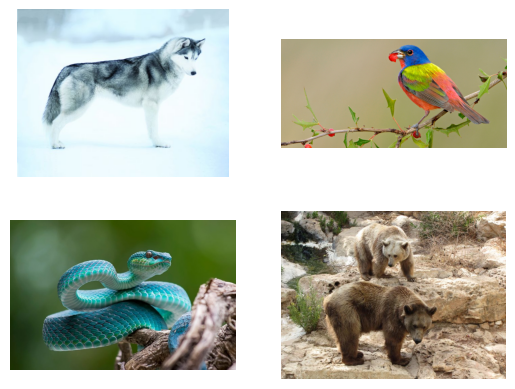

In [ ]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import json

fig, axes = plt.subplots(nrows=2, ncols=2)

for i in range(4):
    img_path = './data/img%d.JPG'%i
    img = Image.open(img_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(img)
    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.axis('off')

# loading labels
with open("./data/imagenet_class_index.json") as json_file:
    d = json.load(json_file)

# **Define preprocess/predict/benchmark helpers**

In [ ]:
import numpy as np
import time
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

def rn50_preprocess():
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess

# decode the results into ([predicted class, description], probability)
def predict(img_path, model):
    img = Image.open(img_path)
    preprocess = rn50_preprocess()
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)
        # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
        sm_output = torch.nn.functional.softmax(output[0], dim=0)

    ind = torch.argmax(sm_output)
    return d[str(ind.item())], sm_output[ind] #([predicted class, description], probability)

def benchmark(model, input_shape=(1024, 1, 224, 224), dtype='fp32', nwarmup=50, nruns=10000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()

    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    start_time_batch = time.time()
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            features = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, ave batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))
    # Calculate throughput
    avg_time = np.mean(timings)*1000
    print(f"size batch {input_data.size(0)}")

    total_samples = input_data.size(0) * nruns
    total_time_seconds = time.time() - start_time_batch
    throughput = total_samples / total_time_seconds
    print("Input shape:", input_data.size())
    print("Output features size:", features.size())
    print('Average batch time: %.2f ms'%(avg_time))
    print('Average throughput: %.2f samples/sec'%(throughput))

    return avg_time ,throughput

# **Classify the 4 images**

./data/img0.JPG - Predicted: ['n02110185', 'Siberian_husky'], Probablility: 0.497873455286026
./data/img1.JPG - Predicted: ['n01820546', 'lorikeet'], Probablility: 0.6447005271911621
./data/img2.JPG - Predicted: ['n01749939', 'green_mamba'], Probablility: 0.4436601400375366
./data/img3.JPG - Predicted: ['n02132136', 'brown_bear'], Probablility: 0.9918118715286255


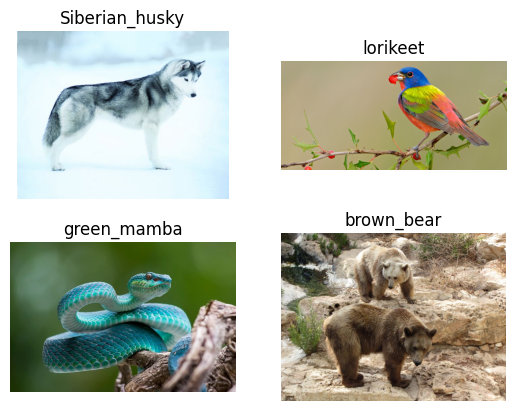

In [ ]:
for i in range(4):
    img_path = './data/img%d.JPG'%i
    img = Image.open(img_path)

    pred, prob = predict(img_path, resnet50_model)
    print('{} - Predicted: {}, Probablility: {}'.format(img_path, pred, prob))

    plt.subplot(2,2,i+1)
    plt.imshow(img);
    plt.axis('off');
    plt.title(pred[1])


# **Baseline PyTorch FP32 GPU benchmark (batch size = 8)**

In [ ]:
benchmark_d = {}
# Force cleanup of RAM objects and release unused GPU cache
import gc
gc.collect()
torch.cuda.empty_cache()
# Model benchmark without Torch-TensorRT
model = resnet50_model.eval().to("cuda")
benchmark_d['pytorch_gpu_8'] = benchmark(model, input_shape=(8, 3, 224, 224), nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 26.50 ms
Iteration 20/100, ave batch time 25.68 ms
Iteration 30/100, ave batch time 25.34 ms
Iteration 40/100, ave batch time 25.58 ms
Iteration 50/100, ave batch time 25.57 ms
Iteration 60/100, ave batch time 25.45 ms
Iteration 70/100, ave batch time 25.35 ms
Iteration 80/100, ave batch time 25.32 ms
Iteration 90/100, ave batch time 25.29 ms
Iteration 100/100, ave batch time 25.24 ms
size batch 8
Input shape: torch.Size([8, 3, 224, 224])
Output features size: torch.Size([8, 1000])
Average batch time: 25.24 ms
Average throughput: 316.63 samples/sec


# **Baseline PyTorch FP32 GPU benchmark (batch size = 16)**

In [ ]:
# Force cleanup of RAM objects and release unused GPU cache
import gc
gc.collect()
torch.cuda.empty_cache()
# Model benchmark without Torch-TensorRT
model = resnet50_model.eval().to("cuda")
benchmark_d['pytorch_gpu_16'] = benchmark(model, input_shape=(16, 3, 224, 224), nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 43.72 ms
Iteration 20/100, ave batch time 43.63 ms
Iteration 30/100, ave batch time 43.74 ms
Iteration 40/100, ave batch time 43.72 ms
Iteration 50/100, ave batch time 43.77 ms
Iteration 60/100, ave batch time 43.82 ms
Iteration 70/100, ave batch time 43.78 ms
Iteration 80/100, ave batch time 43.78 ms
Iteration 90/100, ave batch time 43.82 ms
Iteration 100/100, ave batch time 43.84 ms
size batch 16
Input shape: torch.Size([16, 3, 224, 224])
Output features size: torch.Size([16, 1000])
Average batch time: 43.84 ms
Average throughput: 364.76 samples/sec


In [ ]:
# Force cleanup of RAM objects and release unused GPU cache
import gc
gc.collect()
torch.cuda.empty_cache()

# **FP32 (single precision)**

## **TensorRT FP32 compile & benchmark — ResNet-50 (TorchScript IR, batch size 8)**

In [ ]:
# Trace a function and return an executable  or :class:`ScriptFunction` that will be optimized using just-in-time compilation.
model = resnet50_model.eval().to("cuda")
scripted_model = torch.jit.trace(
            model, torch.randn((8, 3, 224, 224)).to("cuda")
        )

## **torch_tensorrt.compile**
- torch_compile: Use the torch.compile system. Immediately returns a boxed-function that will compile on first call

- dynamo: Run the graph through the torch.export/ torchdynamo stack. If the input module is a torch.nn.Module, it must be “export-traceable” as the module will be traced with torch.export.export. Returns a torch.fx.GraphModule which can be run immediately or saved via torch.export.export or torch_tensorrt.save

- torchscript or ts: Run graph through the TorchScript stack. If the input module is a torch.nn.Module, it must be “scriptable” as the module will be compiled with torch.jit.script. Returns a torch.jit.ScriptModule which can be run immediately or saved via torch.save or torch_tensorrt.save

- fx: Run graph through the torch.fx stack. If the input module is a torch.nn.Module, it will be traced with torch.fx.trace and subject to its limitations.

In [ ]:
import torch_tensorrt

# The compiled module will have precision as specified by "op_precision".
# Here, it will have FP32 precision.
trt_model_fp32 = torch_tensorrt.compile(scripted_model,ir="torchscript", inputs = [torch_tensorrt.Input((8, 3, 224, 224), dtype=torch.float32)],
    enabled_precisions = [torch.float32], # Run with FP32

)

# Obtain the average time taken by a batch of input
benchmark_d['tensort_rt_32_8'] = benchmark(trt_model_fp32, input_shape=(8, 3, 224, 224), nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 18.46 ms
Iteration 20/100, ave batch time 18.34 ms
Iteration 30/100, ave batch time 18.29 ms
Iteration 40/100, ave batch time 18.28 ms
Iteration 50/100, ave batch time 18.50 ms
Iteration 60/100, ave batch time 18.64 ms
Iteration 70/100, ave batch time 18.61 ms
Iteration 80/100, ave batch time 18.62 ms
Iteration 90/100, ave batch time 18.60 ms
Iteration 100/100, ave batch time 18.61 ms
size batch 8
Input shape: torch.Size([8, 3, 224, 224])
Output features size: torch.Size([8, 1000])
Average batch time: 18.61 ms
Average throughput: 429.17 samples/sec


## **TensorRT FP32 compile & benchmark — ResNet-50 (TorchScript IR, batch size 16)**

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

model = resnet50_model.eval().to("cuda")
scripted_model = torch.jit.trace(
            model, torch.randn((16, 3, 224, 224)).to("cuda")
        )

# The compiled module will have precision as specified by "op_precision".
# Here, it will have FP32 precision.
trt_model_fp32_32 = torch_tensorrt.compile(scripted_model,ir="torchscript", inputs = [torch_tensorrt.Input((16, 3, 224, 224), dtype=torch.float32)],
    enabled_precisions = [torch.float32], # Run with FP32

)

# Obtain the average time taken by a batch of input
benchmark_d['tensort_rt_32_16'] = benchmark(trt_model_fp32_32, input_shape=(16, 3, 224, 224), nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 37.73 ms
Iteration 20/100, ave batch time 36.70 ms
Iteration 30/100, ave batch time 37.30 ms
Iteration 40/100, ave batch time 37.13 ms
Iteration 50/100, ave batch time 36.89 ms
Iteration 60/100, ave batch time 37.11 ms
Iteration 70/100, ave batch time 36.96 ms
Iteration 80/100, ave batch time 36.93 ms
Iteration 90/100, ave batch time 37.06 ms
Iteration 100/100, ave batch time 36.94 ms
size batch 16
Input shape: torch.Size([16, 3, 224, 224])
Output features size: torch.Size([16, 1000])
Average batch time: 36.94 ms
Average throughput: 432.76 samples/sec


In [ ]:
gc.collect()
torch.cuda.empty_cache()

# **FP16 (Half precision)**

## **TensorRT FP16 compile & benchmark — ResNet-50 (TorchScript IR, batch size 8)**

In [ ]:
model = resnet50_model.eval().to("cuda")
scripted_model = torch.jit.trace(
            model, torch.randn((8, 3, 224, 224)).to("cuda")
        )

# The compiled module will have precision as specified by "op_precision".
# Here, it will have FP32 precision.
trt_model_fp16 = torch_tensorrt.compile(scripted_model,ir="torchscript", inputs = [torch_tensorrt.Input((8, 3, 224, 224), dtype=torch.half)],
    enabled_precisions = [torch.half], # Run with FP32

)

# Obtain the average time taken by a batch of input
benchmark_d['tensort_rt_16_8'] = benchmark(trt_model_fp16, input_shape=(8, 3, 224, 224), dtype='fp16', nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 4.74 ms
Iteration 20/100, ave batch time 4.62 ms
Iteration 30/100, ave batch time 4.61 ms
Iteration 40/100, ave batch time 4.60 ms
Iteration 50/100, ave batch time 4.62 ms
Iteration 60/100, ave batch time 4.61 ms
Iteration 70/100, ave batch time 4.61 ms
Iteration 80/100, ave batch time 4.61 ms
Iteration 90/100, ave batch time 4.60 ms
Iteration 100/100, ave batch time 4.60 ms
size batch 8
Input shape: torch.Size([8, 3, 224, 224])
Output features size: torch.Size([8, 1000])
Average batch time: 4.60 ms
Average throughput: 1731.96 samples/sec


In [ ]:
gc.collect()
torch.cuda.empty_cache()

## **TensorRT FP16 compile & benchmark — ResNet-50 (TorchScript IR, batch size 16)**

In [ ]:
model = resnet50_model.eval().to("cuda")
scripted_model = torch.jit.trace(
            model, torch.randn((16, 3, 224, 224)).to("cuda")
        )

trt_model_fp16 = torch_tensorrt.compile(scripted_model,ir="torchscript", inputs = [torch_tensorrt.Input((16, 3, 224, 224), dtype=torch.half)],
    enabled_precisions = [torch.half], # Run with FP32

)

benchmark_d['tensort_rt_16_16'] = benchmark(trt_model_fp16, input_shape=(16, 3, 224, 224), dtype='fp16', nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 8.00 ms
Iteration 20/100, ave batch time 7.98 ms
Iteration 30/100, ave batch time 7.98 ms
Iteration 40/100, ave batch time 7.97 ms
Iteration 50/100, ave batch time 7.94 ms
Iteration 60/100, ave batch time 7.97 ms
Iteration 70/100, ave batch time 8.06 ms
Iteration 80/100, ave batch time 8.04 ms
Iteration 90/100, ave batch time 8.03 ms
Iteration 100/100, ave batch time 8.02 ms
size batch 16
Input shape: torch.Size([16, 3, 224, 224])
Output features size: torch.Size([16, 1000])
Average batch time: 8.02 ms
Average throughput: 1991.97 samples/sec


In [ ]:
type(scripted_model)

torch.jit._trace.TopLevelTracedModule

In [ ]:
import pandas as pd
from tabulate import tabulate

df = (pd.DataFrame(benchmark_d).T
        .rename(columns={0: "Avg time (ms)", 1: "Throughput (img/s)"})
        .reset_index()
        .rename(columns={"index": "Run"}))

print(tabulate(df, headers="keys", tablefmt="github", floatfmt=".2f"))


|    | Run              |   Avg time (ms) |   Throughput (img/s) |
|----|------------------|-----------------|----------------------|
|  0 | pytorch_gpu_8    |           25.24 |               316.63 |
|  1 | pytorch_gpu_16   |           43.84 |               364.76 |
|  2 | tensort_rt_32_8  |           18.61 |               429.17 |
|  3 | tensort_rt_32_16 |           36.94 |               432.76 |
|  4 | tensort_rt_16_8  |            4.60 |              1731.96 |
|  5 | tensort_rt_16_16 |            8.02 |              1991.97 |


# **Plot and save inference benchmark charts (latency & throughput)**

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Tuple


def plot_benchmark_results(results: Dict[str, Tuple[float, float]]):
    """
    Plot the benchmark results using Seaborn.

    :param results: Dictionary where the key is the model type and the value is a tuple (average inference time, throughput).
    """
    plot_path = "./inference/tensorrt.png"

    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)

    # Extract data from the results
    models = list(results.keys())
    times = [value[0] for value in results.values()]
    throughputs = [value[1] for value in results.values()]

    # Create DataFrames for plotting
    time_data = pd.DataFrame({"Model": models, "Time": times})
    throughput_data = pd.DataFrame({"Model": models, "Throughput": throughputs})

    # Sort the DataFrames
    time_data = time_data.sort_values("Time", ascending=True)
    throughput_data = throughput_data.sort_values("Throughput", ascending=False)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Plot inference times
    sns.barplot(
        x=time_data["Time"],
        y=time_data["Model"],
        hue=time_data["Model"],
        palette="rocket",
        ax=ax1,
        legend=False,
    )
    ax1.set_xlabel("Average Inference Time (ms)")
    ax1.set_ylabel("Model Type")
    ax1.set_title("ResNet50 - Inference Benchmark Results")
    for index, value in enumerate(time_data["Time"]):
        ax1.text(value, index, f"{value:.2f} ms", color="black", ha="left", va="center")

    # Plot throughputs
    sns.barplot(
        x=throughput_data["Throughput"],
        y=throughput_data["Model"],
        hue=throughput_data["Model"],
        #palette="viridis",
        ax=ax2,
        legend=False,
    )
    ax2.set_xlabel("Throughput (samples/sec)")
    ax2.set_ylabel("")
    ax2.set_title("ResNet50 - Throughput Benchmark Results")
    for index, value in enumerate(throughput_data["Throughput"]):
        ax2.text(value, index, f"{value:.2f}", color="black", ha="left", va="center")

    # Save the plot to a file
    plt.tight_layout()
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()

    print(f"Plot saved to {plot_path}")

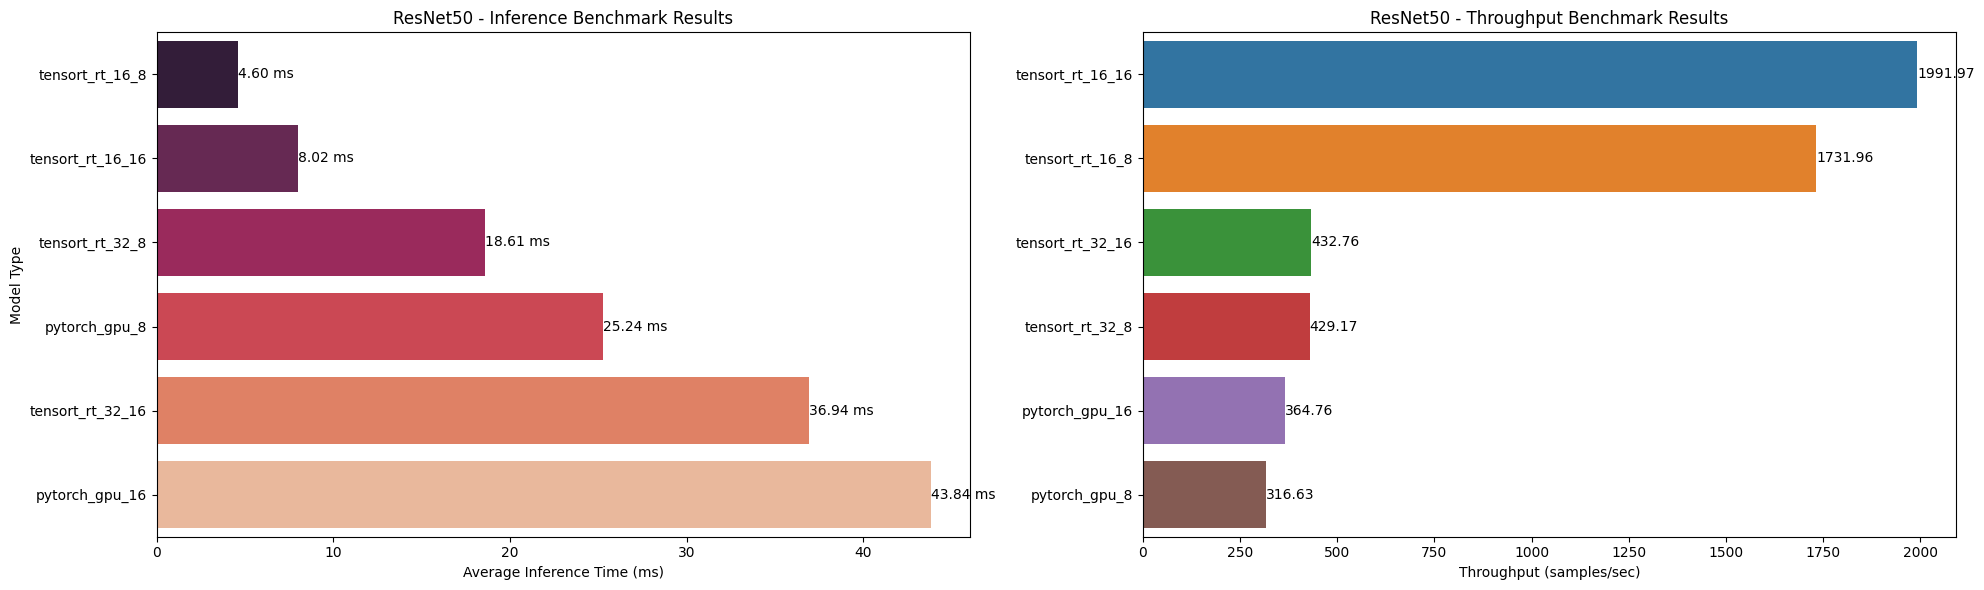

Plot saved to ./inference/tensorrt.png


In [ ]:
plot_benchmark_results(benchmark_d)

## Sources

- NVIDIA Developer Blog - [Accelerating Inference with TensorRT](https://developer.nvidia.com/blog/tag/tensorrt/)  
- NVIDIA TensorRT Documentation - [Quick Start Guide](https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html)  
- ONNX Runtime Documentation — [TensorRT Execution Provider](https://onnxruntime.ai/docs/execution-providers/TensorRT-ExecutionProvider.html)  
